In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%pip install ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.

You should consider upgrading via the 'd:\Documents\stenography\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [34]:
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch

logging.basicConfig(level=logging.INFO)
sys.path.append('..')
from src.models import get_model, SteganographyModels
from src.__main__ import CLI
from src.transformations import get_transformations, Transformations

## Configuration / Constants

In [35]:
# Input values
IMAGE = "../tests/test_images/cat.jpg"
#IMAGE = "../tests/test_messages/cs.png"

MESSAGE_TO_HIDE = "../tests/test_messages/noisette.jpg"
MESSAGE_TO_HIDE = "Hello world"

In [36]:
cli = CLI()

INFO:CLI:Starting your request !


## Loading inputs

INFO:CLI:Loading image.
INFO:CLI:Loading message to hide.
INFO:CLI:We consider this is a plain text


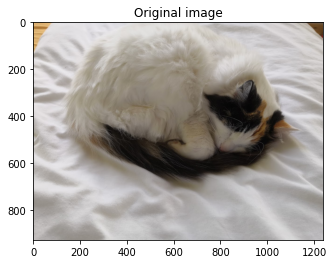

Message to encode
Hello world


In [37]:
# Load the inputs
image = cli._load_image(IMAGE)
message = cli._load_message(MESSAGE_TO_HIDE)

if isinstance(message, str):
    plt.figure()
    plt.imshow(image)
    plt.title("Original image")
    plt.show()
    print("Message to encode")
    print(message[:40])
else:
    # display
    fig, axes = plt.subplots(1, 2, )
    axes[0].imshow(image)
    axes[0].set_title("Original image")
    axes[1].imshow(message)
    axes[1].set_title("Message to hide")
    plt.show()

## Load the models and transformations

In [38]:
model_names = list(SteganographyModels.__members__.keys())
models = {k: get_model(k) for k in model_names}
models = {
    k: v for k,v in models.items()
    if (
        (hasattr(v, "encode_str") and isinstance(message, str))
        or (hasattr(v, "encode_img") and isinstance(message, np.ndarray))
    )
}


In [39]:
models_checkboxes = [widgets.Checkbox(value=True, description=model_name) for model_name in models]
models_output = widgets.VBox(children=models_checkboxes)
print('Select the models you want to use :')
display(models_output)

Select the models you want to use :


In [40]:
transformations_checkboxes = [widgets.Checkbox(value=model_name != "IDENTITY", description=model_name) for model_name in Transformations._member_names_]
transformations_output = widgets.VBox(children=transformations_checkboxes)
print('Select the transformations you want to use :')
display(transformations_output)

Select the transformations you want to use :


In [47]:
selected_models = set([
    checkbox.description for checkbox in models_checkboxes if checkbox.value
])
print(f"Running the pipeline with {', '.join(selected_models)}")

# Delete the useless models to free the ram
to_remove = set()
for k in models:
    if k not in selected_models:
        to_remove.add(k)
for k in to_remove:
    del models[k]


Running the pipeline with GLM, LSB, PVD


In [48]:
selected_transformations = set([
    checkbox.description for checkbox in transformations_checkboxes if checkbox.value
])
print(f"Running the pipeline with {', '.join(selected_transformations)}")

transformations = get_transformations(selected_transformations)

Running the pipeline with 


## Hide the messages

In [49]:
hidden_messages = {}

for model_name, model in models.items():
    try:
        hidden_messages[model_name] = model.encode(image=image, message=message)
    except NotImplementedError:
        logging.warning("Can't use the following model '%s' (not implemented for messages of type %s)", model_name, type(message))
    except Exception as err:
        logging.warning("Can't use the model: '%s'", model_name, exc_info=True)

## Apply transformations to the encrypted messages

In [50]:
# Apply the transformations to each image
def apply_transformations(img: np.ndarray, random_seed: float = 0.) -> np.ndarray:
    """Apply all the transformations."""
    torch.manual_seed(random_seed)
    for transf in transformations:
        img = transf(img)
    return img

random_seed = np.random.random()
hidden_messages_transformed = {
    k: apply_transformations(v, random_seed)
    for k, v in hidden_messages.items()
}

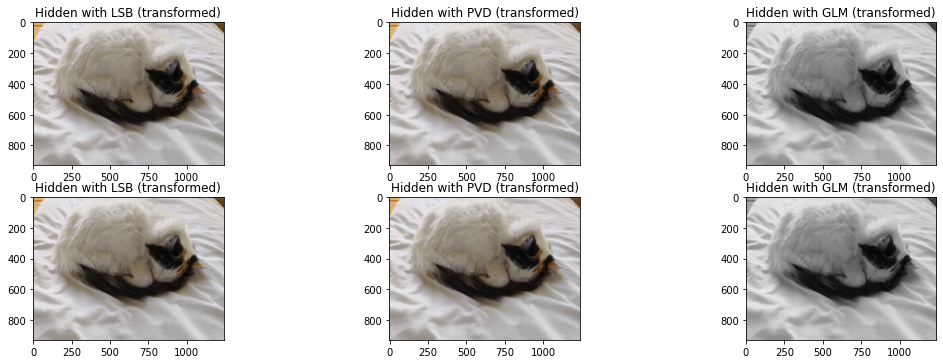

In [51]:
fig, axes = plt.subplots(2, len(hidden_messages), figsize=(5 * len(hidden_messages), 5))
plt.tight_layout()
for before_ax, after_ax, (model_name, hidden_message) in zip(axes[0], axes[1], hidden_messages_transformed.items()):
    before_ax.imshow(hidden_messages[model_name])
    before_ax.set_title(f"Hidden with {model_name} (transformed)")
    after_ax.imshow(hidden_message)
    after_ax.set_title(f"Hidden with {model_name} (transformed)")
plt.show()

## Decrypt the message

In [52]:
retrieved_messages = {}
decode_func = "decode_str" if isinstance(message, str) else "decode_img"
for model_name, hidden_message in hidden_messages_transformed.items():
    print(model_name)
    retrieved_messages[model_name] = getattr(models[model_name], decode_func)(hidden_message)

LSB
PVD
GLM


In [53]:
print({
    k: type(v) for k,v in retrieved_messages.items()
})

{'LSB': <class 'str'>, 'PVD': <class 'str'>, 'GLM': <class 'str'>}


In [54]:
if isinstance(message, str):
    for model_name, retrieved_message in retrieved_messages.items():
        print(f"Model '{model_name}'")
        print(retrieved_message, "\n")
else:
    fig, axes = plt.subplots(1, len(retrieved_messages), figsize=(5 * len(retrieved_messages), 5))
    plt.tight_layout()
    for ax, (model_name, retrieved_message) in zip(axes, retrieved_messages.items()):
        ax.imshow(retrieved_message)
        ax.set_title(f"Hidden with {model_name}")
    plt.show()

Model 'LSB'
Hello world 

Model 'PVD'
Hello world 

Model 'GLM'
Hello world 

